<a href="https://colab.research.google.com/github/cnhzgb/MachineL/blob/main/GAN_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install einops
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from einops import rearrange
from torchsummary import summary
import time

device = "cuda" if torch.cuda.is_available() else "cpu"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 418.7 kB/s eta 0:00:00


In [ ]:
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
dataset = datasets.CIFAR10(root="dataset/", transform=trans, download=True, train=True) # 5W张图片, 10种分类
loader = DataLoader(dataset, batch_size=100, shuffle=True)
batch_num,(image, label) = next(enumerate(loader))
print(len(dataset.classes), len(dataset), image.shape, label.shape) # 10; 5W; 100,3,32,32; 100

trans_test = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
dataset_test = datasets.CIFAR10(root="dataset/", transform=trans_test, download=True, train=False) # 1W张图片
loader_test = DataLoader(dataset_test, batch_size=100, shuffle=True)
criterion_test = nn.CrossEntropyLoss()

100%|██████████| 170498071/170498071 [00:06<00:00, 28168449.66it/s]


Extracting dataset/cifar-10-python.tar.gz to dataset/
10 50000 torch.Size([100, 3, 32, 32]) torch.Size([100])
Files already downloaded and verified


In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.disc = nn.Sequential(
      nn.Linear(in_features=32*32*3, out_features=1024),
      nn.LeakyReLU(0.01),
      nn.Linear(1024, 16),
      nn.LeakyReLU(0.01),
      nn.Linear(16, 1),
      nn.Sigmoid()  # 将输出值映射到0-1之间
    )

  def forward(self, x):
    return self.disc(x)

class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.gen = nn.Sequential(
      nn.Linear(128, 1024),
      nn.LeakyReLU(0.01),
      nn.Linear(1024, 32*32*3),
      nn.Tanh()
    )

  def forward(self, x):
    return self.gen(x)

fixed_noise = torch.randn((100, 128)).to(device)
D = Discriminator().to(device)
G = Generator().to(device)
opt_disc = optim.Adam(D.parameters(), lr=1e-4)
opt_gen = optim.Adam(G.parameters(), lr=1e-4)
criterion = nn.BCELoss()

summary(D, input_size = (1,32*32*3))
summary(G, (1,128))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 1024]       3,146,752
         LeakyReLU-2              [-1, 1, 1024]               0
            Linear-3                [-1, 1, 16]          16,400
         LeakyReLU-4                [-1, 1, 16]               0
            Linear-5                 [-1, 1, 1]              17
           Sigmoid-6                 [-1, 1, 1]               0
Total params: 3,163,169
Trainable params: 3,163,169
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 12.07
Estimated Total Size (MB): 12.09
----------------------------------------------------------------
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [

Epoch 1 lossD 0.00 lossG 9.09 costTime 14.7


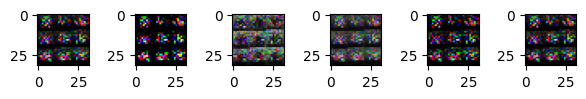

Epoch 2 lossD 0.01 lossG 5.65 costTime 16.0


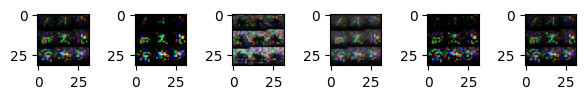

Epoch 3 lossD 0.00 lossG 5.54 costTime 15.1


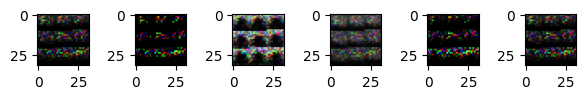

Epoch 4 lossD 0.00 lossG 5.93 costTime 14.7


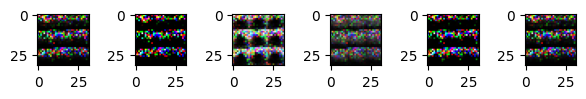

Epoch 5 lossD 0.00 lossG 9.21 costTime 14.8


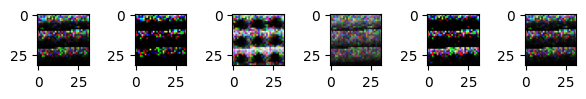

Epoch 6 lossD 0.00 lossG 7.06 costTime 16.5


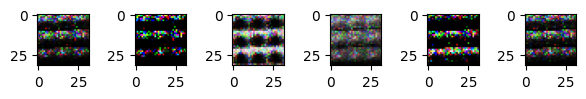

Epoch 7 lossD 0.00 lossG 6.43 costTime 14.7


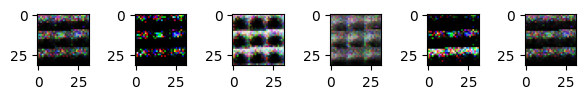

Epoch 8 lossD 0.01 lossG 7.08 costTime 14.7


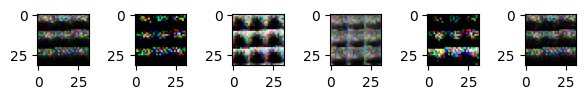

Epoch 9 lossD 0.05 lossG 8.57 costTime 14.6


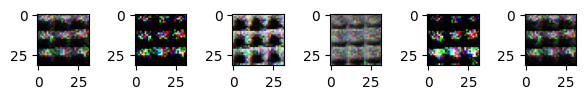

Epoch 10 lossD 0.00 lossG 6.54 costTime 15.4


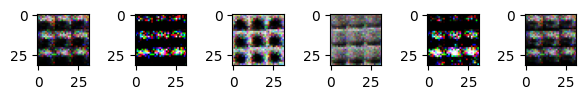

Epoch 11 lossD 0.03 lossG 6.06 costTime 14.7


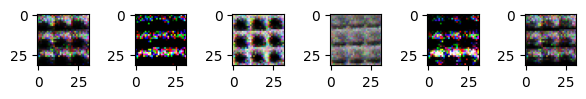

Epoch 12 lossD 0.00 lossG 7.72 costTime 14.7


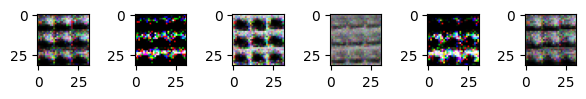

Epoch 13 lossD 0.02 lossG 6.16 costTime 14.7


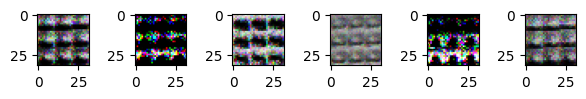

Epoch 14 lossD 0.01 lossG 5.77 costTime 15.6


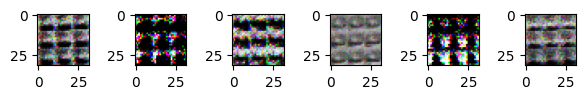

In [ ]:
for epoch in range(1,50):
  start_time = time.time()
  for batch_idx, (img, label) in enumerate(loader): # 100,3,32,32 6W张图片
    batch_size = img.shape[0]

    noise = torch.randn(batch_size, 128).to(device)
    fake_img = G(noise) # 32*32*3
    disc_fake = D(fake_img)
    lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))    # 虚假数据与0计算损失

    img = img.view(-1, 32*32*3).to(device)
    disc_real = D(img)
    lossD_real = criterion(disc_real, torch.ones_like(disc_real))     # 真实数据与1计算损失

    lossD = (lossD_real + lossD_fake) / 2
    D.zero_grad()
    lossD.backward(retain_graph=True)
    opt_disc.step()

    output = D(fake_img)
    lossG = criterion(output, torch.ones_like(output))
    G.zero_grad()
    lossG.backward()
    opt_gen.step()

    if batch_idx == len(dataset)/100-1:
      time_cost = time.time() - start_time
      print( "Epoch {} lossD {:.2f} lossG {:.2f} costTime {:.1f}".format(epoch, lossD, lossG, time_cost))
      with torch.no_grad():
        fimg = G(fixed_noise).reshape(-1, 32, 32, 3)
        fig, axs = plt.subplots(1, 6, figsize=(6, 1))
        for i, ax in enumerate(axs.flatten()):
          ax.imshow(fimg[i].cpu()*0.5+0.5)
        plt.tight_layout()
        plt.show()
